In [47]:
# downloading helper_functions.py
! wget https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py

--2024-09-23 18:12:02--  https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10139 (9.9K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   9.90K  --.-KB/s    in 0s      

2024-09-23 18:12:03 (41.0 MB/s) - ‘helper_functions.py.1’ saved [10139/10139]



In [48]:
!pip install tensorflow==2.15.0
!pip install pillow
!pip install streamlit==0.82.0

In [49]:
# Importing dependancies
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_functions import plot_loss_curves, compare_historys, make_confusion_matrix

In [50]:
from google.colab import files
uploaded = files.upload()  # This will open a dialog to upload files

In [51]:
import zipfile
import os

# Assuming the folder name is 'my_folder.zip'
zip_file = "my_folder.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/my_folder")

FileNotFoundError: [Errno 2] No such file or directory: 'my_folder.zip'

In [52]:
oil_dir = "/content/drive/MyDrive/skin-dataset/dry"
dry_dir = "/content/drive/MyDrive/skin-dataset/dry"

In [53]:
# Getting all the paths in a list for oil and dry skins
oil_list = []
for path in os.listdir(oil_dir):
  oil_list.append(oil_dir + "/" + path)

dry_list = []
for path in os.listdir(dry_dir):
  dry_list.append(dry_dir + "/" + path)

In [54]:
oil_list[0]

'/content/drive/MyDrive/skin-dataset/dry/dry(189).jpg'

In [55]:
# Preprocess img function
IMG_SIZE = (224, 224)
def load_and_prep(filepath):
  img_path = tf.io.read_file(filepath)
  img = tf.io.decode_image(img_path)
  img = tf.image.resize(img, IMG_SIZE)

  return img

In [56]:
# Getting only those images which are suitable
def corrImgs(arr):
  corrImgList = []
  for path in arr:
    img = load_and_prep(path)
    if (img.shape[2] == 3) | (img.shape == 4):
      corrImgList.append(path)

  return corrImgList

In [57]:
# Randomly plotting the Oily Skin images
random_oil_skin = np.random.choice(oil_list, size=12, replace=False)
plt.figure(figsize=(17, 12))
for i in range(12):
  img_path = random_oil_skin[i]
  img = load_and_prep(img_path)

  # plotting the images
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(img/255)
  plt.title("Oily Skin", color="green")

Output hidden; open in https://colab.research.google.com to view.

In [58]:
# Randomly plotting the Dry Skin images
random_dry_skin = np.random.choice(dry_list, size=12, replace=False)
plt.figure(figsize=(17, 12))
for i in range(12):
  img_path = random_dry_skin[i]
  img = load_and_prep(img_path)

  # plotting the images
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(img/255)
  plt.title("Dry Skin", color="green")

Output hidden; open in https://colab.research.google.com to view.

In [59]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

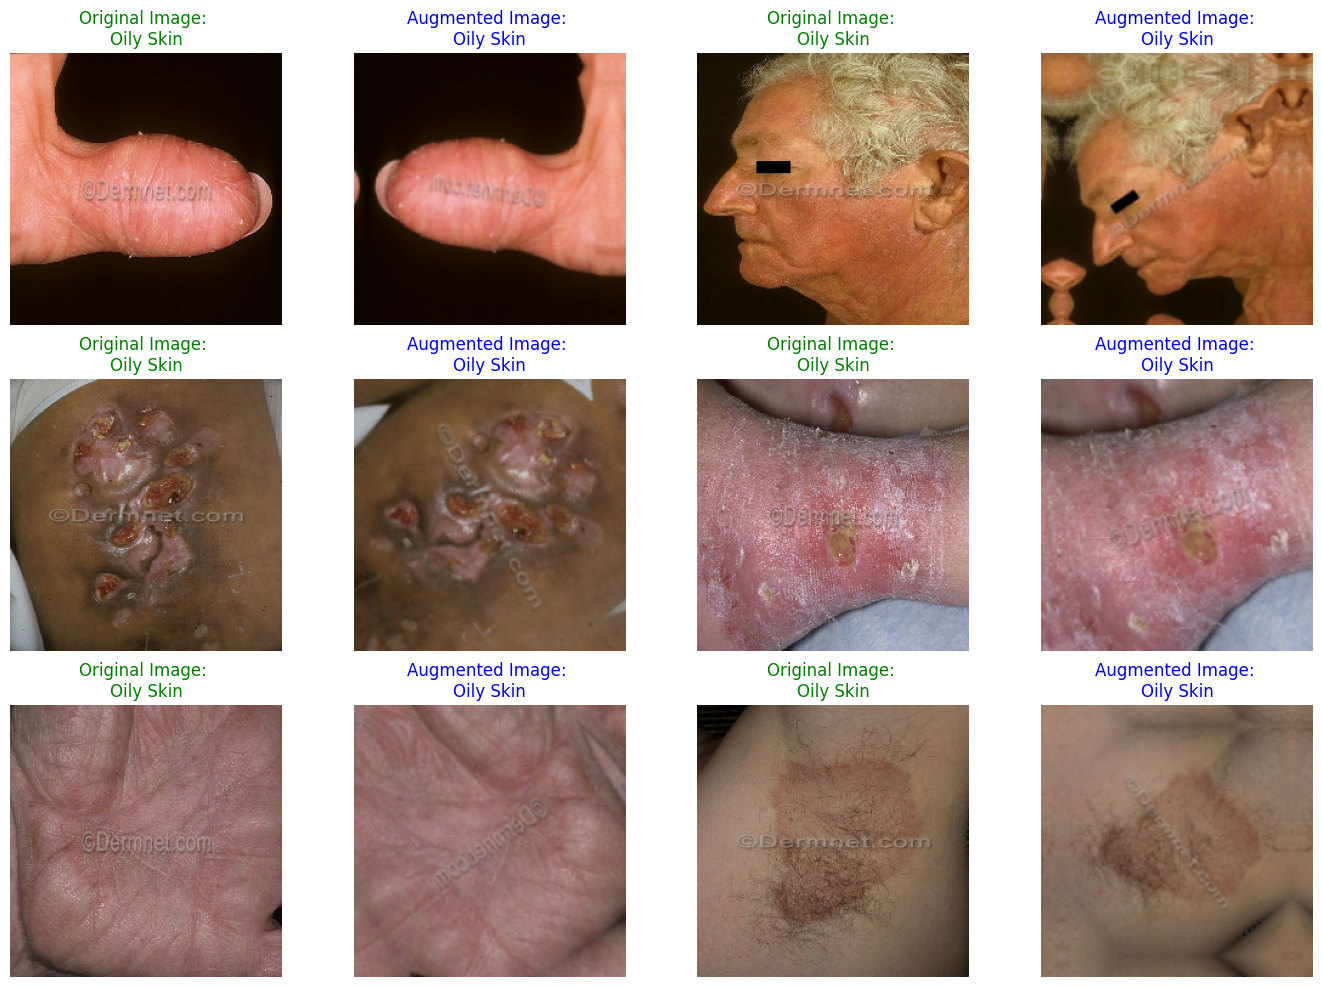

In [60]:
# Visualizing multiple randomly augmented oily skin images
plt.figure(figsize=(17, 12))
for i in range(1, 12, 2):
  random_class = "Oily Skin"
  random_img_path = random.choice(oil_list)

  img = load_and_prep(random_img_path)
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))
  aug_img = tf.image.resize(aug_img[0], IMG_SIZE)

  # Plotting original image
  plt.subplot(3, 4, i)
  plt.axis(False)
  plt.imshow(img / 255)
  plt.title(f"Original Image: \n{random_class}", color="green")

  # Plotting augmented image
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(aug_img / 255)
  plt.title(f"Augmented Image: \n{random_class}", color="blue");

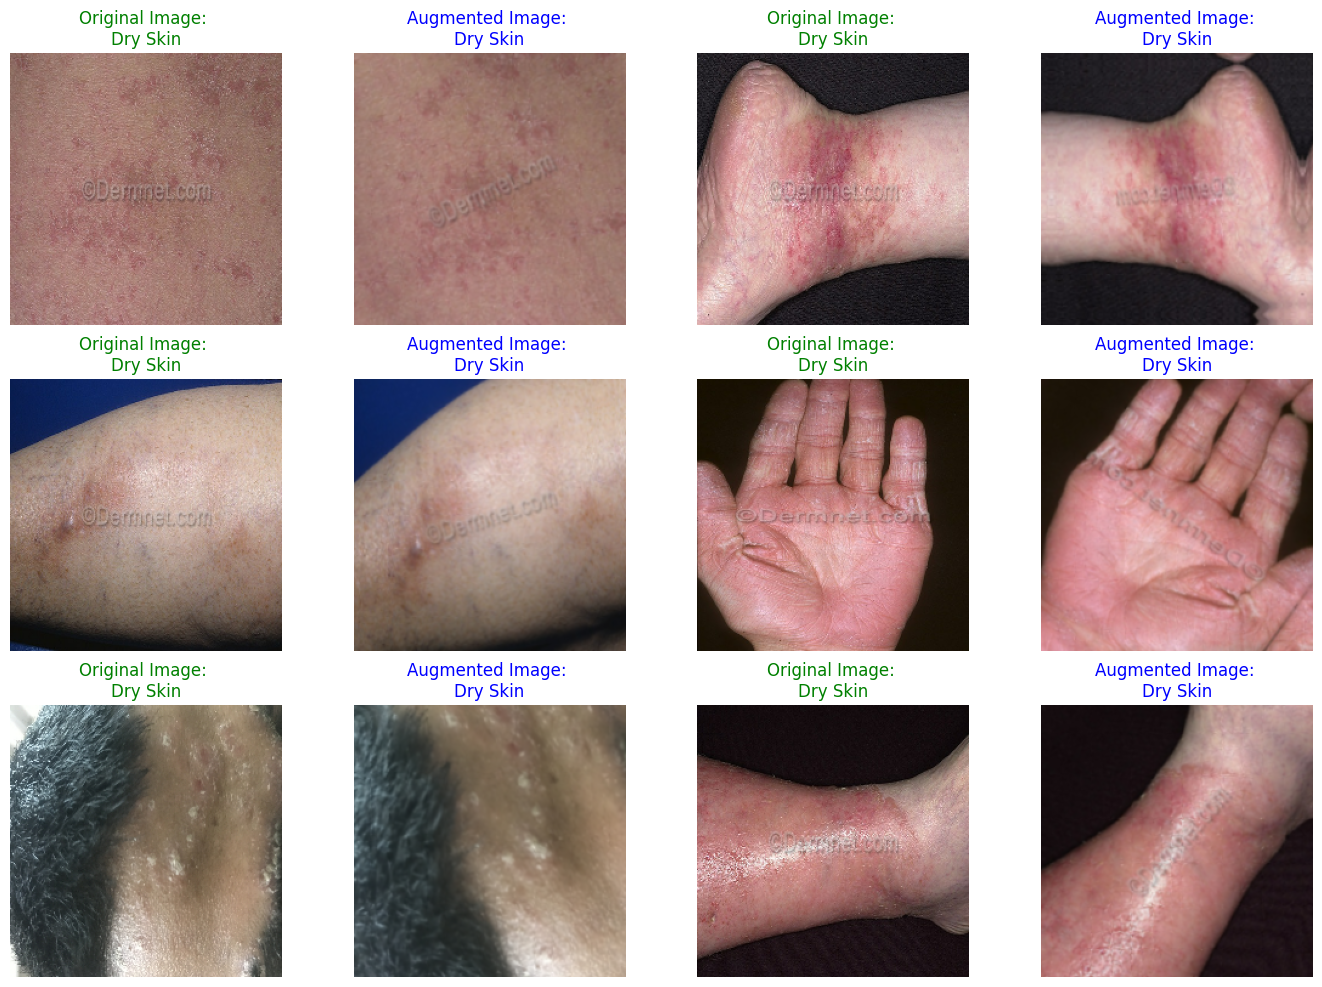

In [61]:
# Visualizing multiple randomly augmented dry skin images
plt.figure(figsize=(17, 12))
for i in range(1, 12, 2):
  random_class = "Dry Skin"
  random_img_path = random.choice(dry_list)

  img = load_and_prep(random_img_path)
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))
  aug_img = tf.image.resize(aug_img[0], IMG_SIZE)

  # Plotting original image
  plt.subplot(3, 4, i)
  plt.axis(False)
  plt.imshow(img / 255)
  plt.title(f"Original Image: \n{random_class}", color="green")

  # Plotting augmented image
  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.imshow(aug_img / 255)
  plt.title(f"Augmented Image: \n{random_class}", color="blue");

In [62]:
# Train test splits
data_gen = ImageDataGenerator(validation_split=0.2)

train_data = data_gen.flow_from_directory(directory="/content/drive/MyDrive/skin-dataset",
                                          subset='training',
                                          target_size=IMG_SIZE)

test_data = data_gen.flow_from_directory(directory="/content/drive/MyDrive/skin-dataset",
                                         subset='validation',
                                         target_size=IMG_SIZE)

Found 412 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [63]:
# Setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting up input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = tf.keras.layers.Dense(2, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# compiling the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25 * len(test_data))

Epoch 1/5
13/13 [==============================] - 58s 4s/step - loss: 0.5207 - accuracy: 0.7257 - val_loss: 0.4214 - val_accuracy: 0.7500
Epoch 2/5
13/13 [==============================] - 43s 3s/step - loss: 0.3177 - accuracy: 0.8811 - val_loss: 0.3137 - val_accuracy: 0.8438
Epoch 3/5
13/13 [==============================] - 50s 4s/step - loss: 0.2368 - accuracy: 0.9345 - val_loss: 0.2419 - val_accuracy: 0.9062
Epoch 4/5
13/13 [==============================] - 51s 4s/step - loss: 0.1994 - accuracy: 0.9369 - val_loss: 0.1417 - val_accuracy: 0.9688
Epoch 5/5
13/13 [==============================] - 43s 3s/step - loss: 0.1781 - accuracy: 0.9417 - val_loss: 0.1419 - val_accuracy: 0.9375


In [65]:
# Evaluating the model
model_1.evaluate(test_data)

4/4 [==============================] - 17s 3s/step - loss: 0.1563 - accuracy: 0.9314


[0.15629808604717255, 0.9313725233078003]

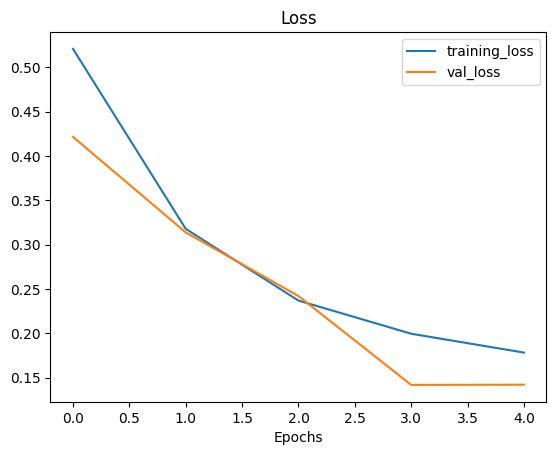

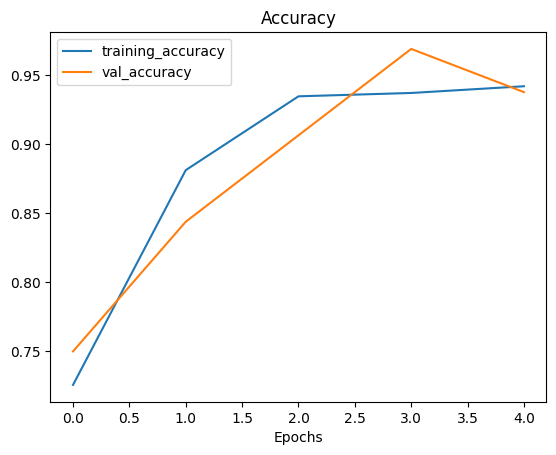

In [66]:
# Plotting loss curves
plot_loss_curves(history_1)

In [68]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 10

history_1_fine_tune_1 = model_1.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=test_data,
                                    validation_steps= 0.25 * len(test_data),
                                    initial_epoch=history_1.epoch[-1])

Epoch 5/10
13/13 [==============================] - 71s 4s/step - loss: 0.1580 - accuracy: 0.9563 - val_loss: 0.0547 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 47s 4s/step - loss: 0.1160 - accuracy: 0.9539 - val_loss: 0.0415 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 46s 3s/step - loss: 0.1079 - accuracy: 0.9587 - val_loss: 0.0788 - val_accuracy: 0.9688
Epoch 8/10
13/13 [==============================] - 45s 3s/step - loss: 0.0977 - accuracy: 0.9709 - val_loss: 0.0908 - val_accuracy: 0.9688
Epoch 9/10
13/13 [==============================] - 49s 4s/step - loss: 0.0845 - accuracy: 0.9684 - val_loss: 0.0924 - val_accuracy: 0.9688
Epoch 10/10
13/13 [==============================] - 47s 4s/step - loss: 0.0817 - accuracy: 0.9733 - val_loss: 0.0378 - val_accuracy: 1.0000


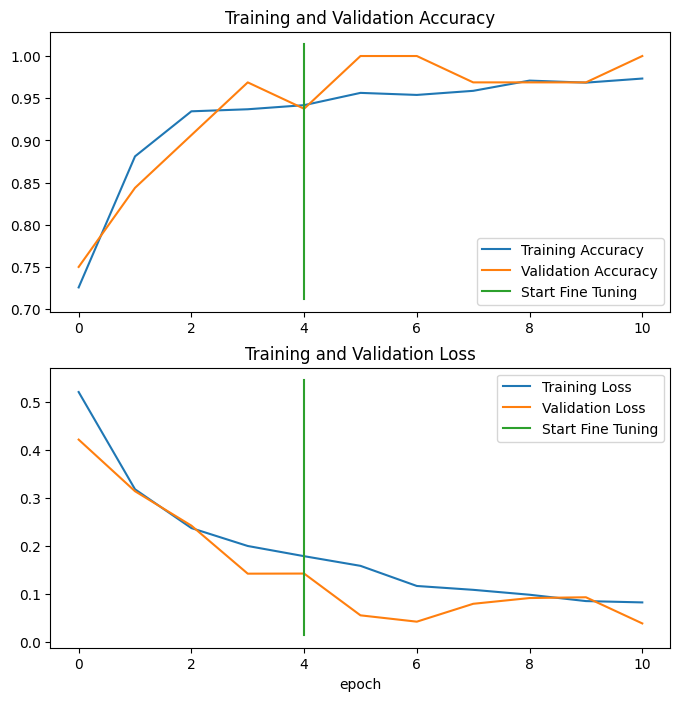

In [69]:
compare_historys(history_1, history_1_fine_tune_1)

In [70]:
# Model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, None   0         
 equential)                  )                                   
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                           

In [71]:
# Getting test image file paths
test_data_img_paths = test_data.filepaths
np.random.shuffle(test_data_img_paths)

# Getting labels
test_data_labels = []
for path in test_data_img_paths:

    test_data_labels.append(path.split("/")[-2])

# Creating a dataframe of test paths
df_test_data_img_paths = pd.DataFrame({"Img Paths": test_data_img_paths,
                                       "Labels": test_data_labels})

df_test_data_img_paths.head()

Img Paths Labels
0  /content/drive/MyDrive/skin-dataset/oily/oily(...   oily
1  /content/drive/MyDrive/skin-dataset/dry/dry(16...    dry
2  /content/drive/MyDrive/skin-dataset/dry/dry(12...    dry
3  /content/drive/MyDrive/skin-dataset/oily/oily(...   oily
4  /content/drive/MyDrive/skin-dataset/oily/oily(...   oily

In [72]:
# Generating a test dataset for
test_data_shuff = data_gen.flow_from_dataframe(df_test_data_img_paths,
                                               directory="C:/Users/junsu/Real-TIme-Skin-Type-Detection/Real-TIme-Skin-Type-Detection/skin-dataset",
                                               x_col='Img Paths', y_col='Labels',
                                               shuffle=False,
                                               target_size=(224, 224))

Found 102 validated image filenames belonging to 2 classes.


In [73]:
# Saving the model
model_1.save("/content/drive/MyDrive/Skin-Type-Recognition", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [74]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Skin-Type-Recognition")

In [75]:
# Getting prediction probabilites
pred_prob = model.predict(test_data_shuff)
pred_prob[:20]

4/4 [==============================] - 12s 2s/step


array([[6.69436082e-02, 9.33056355e-01],
       [9.97933567e-01, 2.06639501e-03],
       [9.97719347e-01, 2.28067767e-03],
       [3.22420821e-02, 9.67757940e-01],
       [1.07441835e-01, 8.92558098e-01],
       [9.99965608e-01, 3.43664724e-05],
       [9.99966800e-01, 3.31071169e-05],
       [9.99960721e-01, 3.92364745e-05],
       [1.51449487e-01, 8.48550618e-01],
       [9.03596759e-01, 9.64032039e-02],
       [9.99930441e-01, 6.95284034e-05],
       [9.99979794e-01, 2.01912753e-05],
       [9.99981701e-01, 1.82354361e-05],
       [9.99970138e-01, 2.98508712e-05],
       [9.99988854e-01, 1.10508145e-05],
       [9.93525922e-01, 6.47402881e-03],
       [9.99029577e-01, 9.70426248e-04],
       [9.99841452e-01, 1.58553186e-04],
       [9.78179336e-01, 2.18206272e-02],
       [9.99996245e-01, 3.65124288e-06]], dtype=float32)

In [76]:
y_pred = pred_prob.argmax(axis=1)
y_pred[:20]

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [77]:
# Labels
test_data.class_indices

{'dry': 0, 'oily': 1}

In [78]:
# Converting our text labels into numbers
y_true = []
for label in test_data_labels:
  label_ = 0 if label == "dry" else 1
  y_true.append(label_)

y_true  = np.array(y_true)
y_true[:20]

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

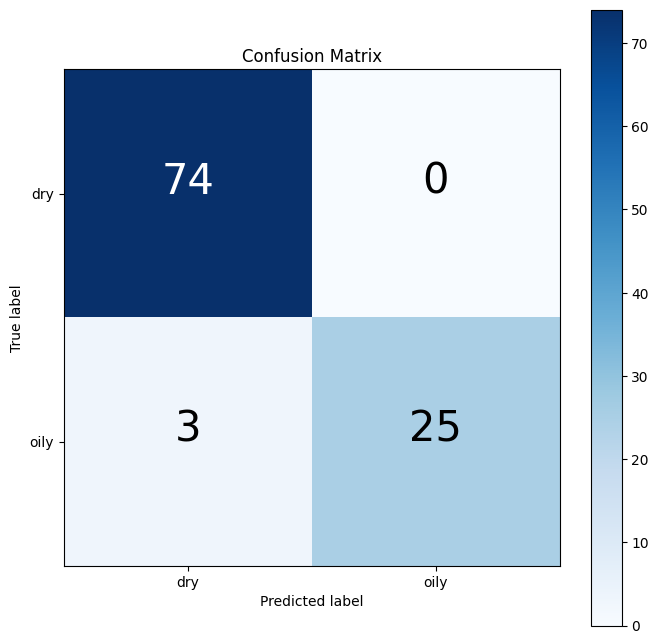

In [79]:
# Plotting a confusion matrix
class_names = ["dry", "oily"]

make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(8, 8),
                      text_size=30,
                      norm=False)

In [80]:
# To get suitable images
corrImgList = corrImgs(test_data_img_paths)

In [81]:
path_list = np.random.choice(corrImgList, size=12, replace=False)
plt.figure(figsize=(17, 12))
for i in range(12):
  img_path = path_list[i]
  class_name = img_path.split("/")[5]
  img = load_and_prep(img_path)

  pred_prob  = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
  plt.subplot(3, 4, i+1)
  plt.imshow(img/255.)
  title_color = "g" if class_name == pred_class else "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, \nprob: {pred_prob.max():.2f}%", c=title_color)
  plt.axis(False);

Output hidden; open in https://colab.research.google.com to view.

In [82]:
# Getting test labels
test_labels = []
for path in test_data_img_paths:
  test_labels.append(path.split("/")[-2])

test_labels[:5]

['oily', 'dry', 'dry', 'oily', 'oily']

In [83]:
df_pred = pd.DataFrame({"filename" : test_data_img_paths,
                         "label": test_labels,
                         "True": y_true,
                         "pred": y_pred})

df_pred.head(10)

filename label  True  pred
0  /content/drive/MyDrive/skin-dataset/oily/oily(...  oily     1     1
1  /content/drive/MyDrive/skin-dataset/dry/dry(16...   dry     0     0
2  /content/drive/MyDrive/skin-dataset/dry/dry(12...   dry     0     0
3  /content/drive/MyDrive/skin-dataset/oily/oily(...  oily     1     1
4  /content/drive/MyDrive/skin-dataset/oily/oily(...  oily     1     1
5  /content/drive/MyDrive/skin-dataset/dry/dry(14...   dry     0     0
6  /content/drive/MyDrive/skin-dataset/dry/dry(16...   dry     0     0
7  /content/drive/MyDrive/skin-dataset/dry/dry(13...   dry     0     0
8  /content/drive/MyDrive/skin-dataset/oily/oily(...  oily     1     1
9  /content/drive/MyDrive/skin-dataset/dry/dry(13...   dry     0     0

In [84]:
# Wrong predicted images
wrng_pred_test_paths = []
for i in range(len(test_data_img_paths)):
  if y_true[i] != y_pred[i]:
    print(y_true[i],"   ",y_pred[i])
    wrng_pred_test_paths.append(test_data_img_paths[i])

len(wrng_pred_test_paths)

1     0
1     0
1     0


3

In [85]:
wrng_pred_test_paths

['/content/drive/MyDrive/skin-dataset/oily/oily(110).jpg',
 '/content/drive/MyDrive/skin-dataset/oily/oily(12).jpeg',
 '/content/drive/MyDrive/skin-dataset/oily/oily(11).jpeg']

1/1 [==============================] - 0s 99ms/step


IndexError: list index out of range

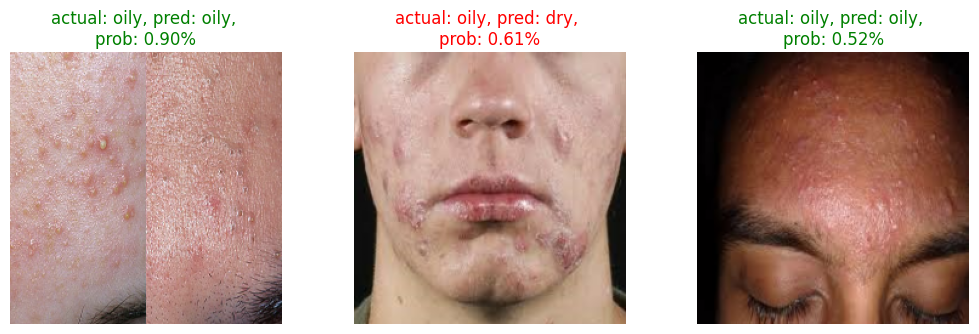

In [86]:
# Wrongly predicted images
plt.figure(figsize=(17, 12))
for i in range(len0(wrng_pred_test_paths)):
  img_path = wrng_pred_test_paths[i]
  class_name = img_path.split("/")[-2]
  img = load_and_prep(img_path)

  pred_prob  = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
  plt.subplot(3, 4, i+1)
  plt.imshow(img/255.)
  title_color = "g" if class_name == pred_class else "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, \nprob: {pred_prob.max():.2f}%", c=title_color)
  plt.axis(False);